#San Francisco Crime Prediction 

We are involved in the kaggle.com Crime Prediction contest. We are using the data provided about crimes that occurred in San Francisco from 2011 to 2015. The data are variations on time and location, and the labels on the training set are 39 different crimes. 

To solve this problem we use various models and feature engineering. 

##Initial Attempt

To get on the leaderboard, we did basic feature extraction and normalization, and used a logistric regression model. 

###Initial Feature Engineering Summary

These are the features we get in both training and test data sets.

| Date | DayOfWeek | PdDistrict | Address | Longitude | Latitude |
|---|---|---|---|---|---|---|---|
| 2015-05-10 23:59:00 | Sunday | BAYVIEW | 2000 Block of THOMAS AV | -122.3995877042 | 37.7350510104 |

For the initial attempt, we immediate made these modifications: 

* Semi-normalize years: subtract lowest year, 2011, so that year numbers are from 0 to 4. 
* Separate time information into year, month, day, time of day, day of week
* Normalize latitude and longitude (use (value - mean)/standard deviation)

And chose a logistic regression model for these reasons: 
* Predicting categorical dependent variable
* Relatively large number of samples, not so many features
* Mixture of categorical and continuous data
* Data with obvious correlation (so linear regression would be worse)
* Non-normally distributed data

The results of this attempt are summarized here: 

|  Model | Accuracy | Train Time | Kaggle Score |
|---|---|---|---|---|---|---|---|
| Keras NeuralNet | 33% | 1 hour| 64th |
| Logistic Regression | 30%| few minutes | 105th |



In [ ]:
%matplotlib inline

# General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# Keras
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils

# Data Exploration

Initial step was to explore the data. As part of this step, we did the following:

1. Number of Unique values for each and every variable
2. Find the most common values

Observations:
1. Invalid values present in Y coordinates (for example, Y = 90 which is invalid)
2. Detailed Address feature engineering is captured in an excel sheet.

In [23]:
data_df = pd.read_csv("../train.csv")
test_data_df = pd.read_csv("../test.csv")

for field, values in data_df.iteritems():
    print "Total number of Unique values for " + field + ": " + str(len(values.value_counts()))
    


Total number of Unique values for Dates: 389257
Total number of Unique values for Category: 39
Total number of Unique values for Descript: 879
Total number of Unique values for DayOfWeek: 7
Total number of Unique values for PdDistrict: 10
Total number of Unique values for Resolution: 17
Total number of Unique values for Address: 23228
Total number of Unique values for X: 34243
Total number of Unique values for Y: 34243


In [41]:
import operator
from string import capwords
import seaborn as sns

# Plotting Options
sns.set_style("whitegrid")
sns.despine()
def plot_bar(df, title, filename):
    p = (
        'Set2', 'Paired', 'colorblind', 'husl',
        'Set1', 'coolwarm', 'RdYlGn', 'spectral'
    )
    bar = df.plot(kind='barh',
                  title=title,
                  fontsize=8,
                  figsize=(12,8),
                  stacked=False,
                  width=1,
                  colors = sns.color_palette(np.random.choice(p), len(df)),
    )

    bar.figure.savefig(filename)
    
    plt.show()

def plot_top_crimes(df, column, title, fname, items=0):
    df.columns     = df.columns.map(operator.methodcaller('lower'))
    by_col         = df.groupby(column) 
    col_freq       = by_col.size()
    col_freq.index = col_freq.index.map(capwords)

    col_freq.sort(ascending=True, inplace=True)
    plot_bar(col_freq[slice(-1, - items, -1)], title, fname)

    

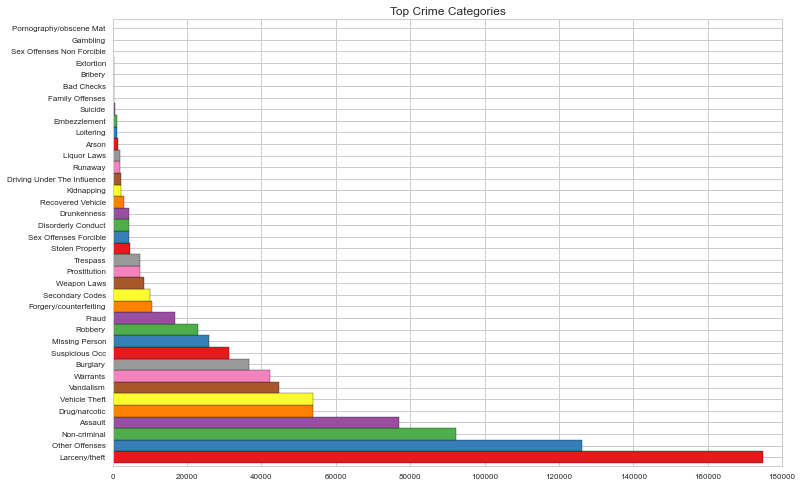

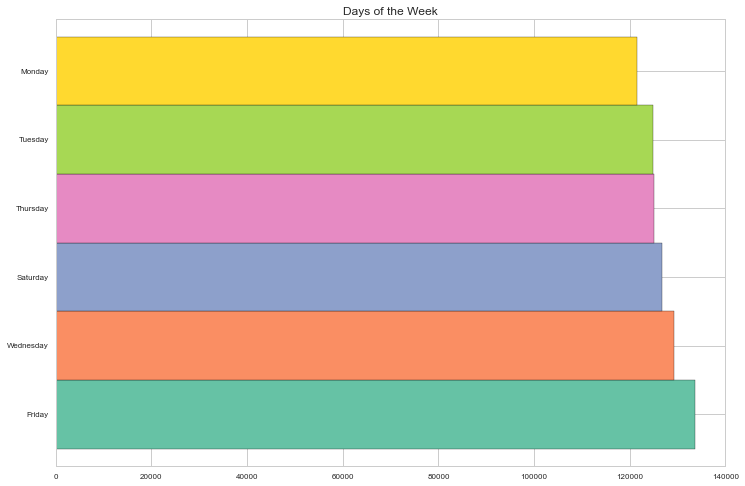

In [50]:
plot_top_crimes(data_df, 'category',   'Top Crime Categories',        'category.png')
plot_top_crimes(data_df, 'dayofweek',  'Days of the Week',            'weekly.png')

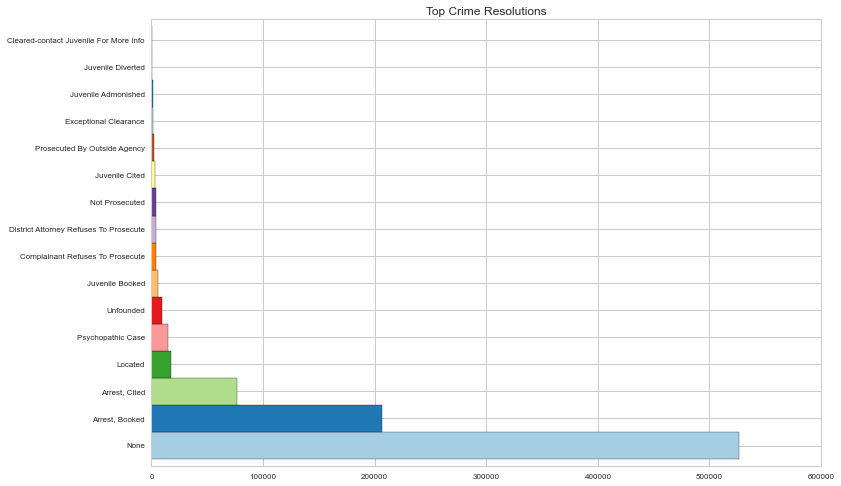

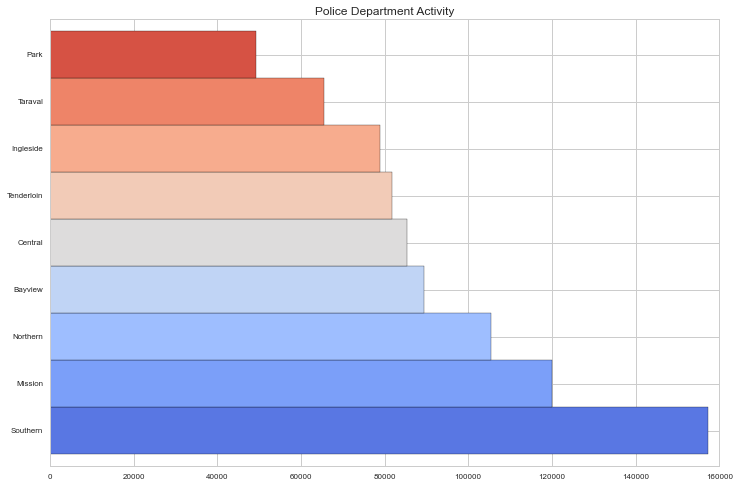

In [51]:
plot_top_crimes(data_df, 'resolution', 'Top Crime Resolutions',       'resolution.png')
plot_top_crimes(data_df, 'pddistrict', 'Police Department Activity',  'police.png')

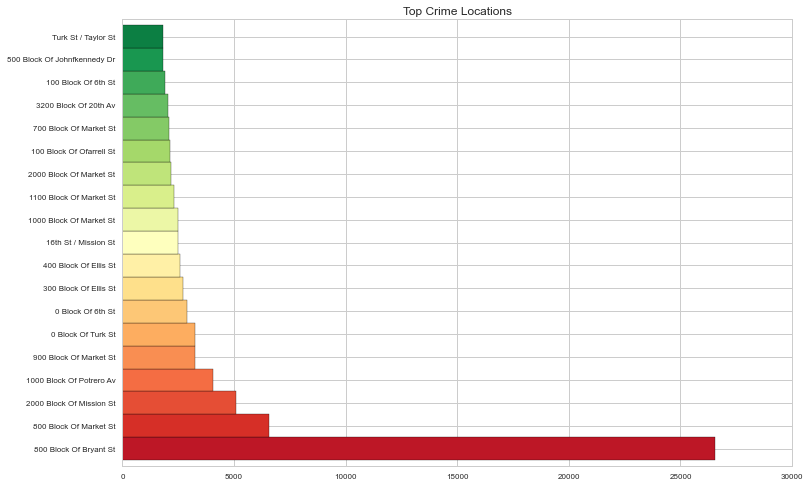

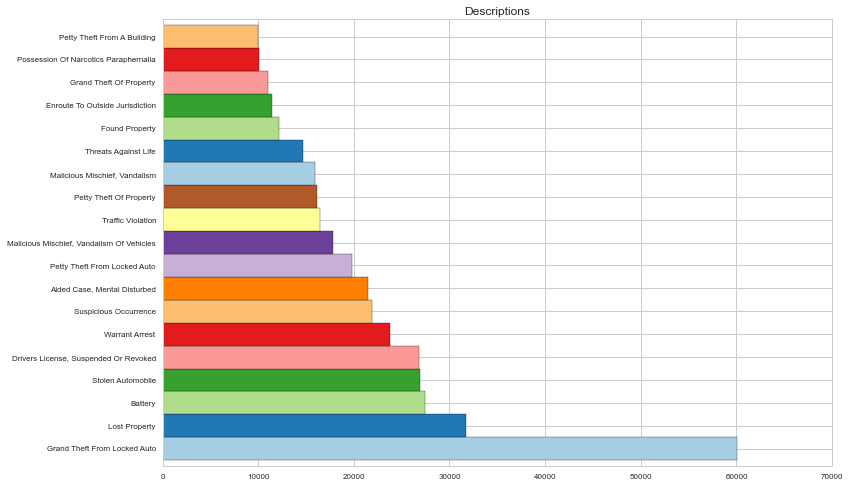

In [52]:
plot_top_crimes(data_df, 'address',    'Top Crime Locations',         'location.png', items=20)
plot_top_crimes(data_df, 'descript',   'Descriptions',                'descript.png', items=20)

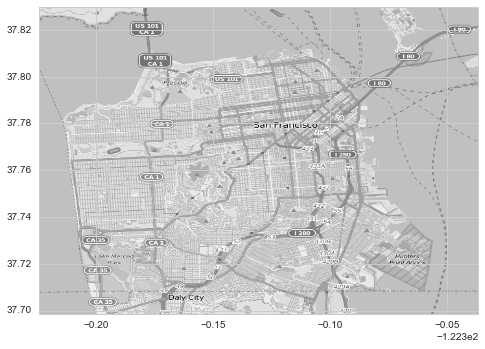

In [46]:
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'), extent=[-122.52469, -122.33663, 37.69862, 37.82986])
#plt.imshow(mapdata, cmap = plt.get_cmap('gray'))
plt.savefig('map.png')

# I. Feature Engineering

In [4]:
districts = ['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']
week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daytime = ['Twilight', 'Morning', 'Afternoon', 'Night']
year_range = ['2003-2006', '2006-2009', '2009-2012', 'After 2015']
crime_year = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
crime_month = ['JAN', 'FEB', 'MAR','APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crime_day = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29' ,'30' ,'31']
crime_hour = ['Midnight', '0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', '1000', '1100', 'Noon', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']

## Date Feature Engineering
We initially worked on Date Feature Engineering. We initially tried to do the feature engineering with NUMPY arrays, but Pandas data frame is very powerful and flexible. And so we ended up using Pandas for date feature engineering

In [5]:
def feature_engineering(data):
    data['CrimeDateTime'] = pd.to_datetime(data['Dates'])
    data['Year'] = pd.DatetimeIndex(data['CrimeDateTime']).year
    data['Month'] = pd.DatetimeIndex(data['CrimeDateTime']).month
    data['Day'] = pd.DatetimeIndex(data['CrimeDateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['CrimeDateTime']).hour
    data['TimeinSeconds'] = (data.CrimeDateTime - pd.Timestamp('2013-06-01'))/np.timedelta64(1,'s')
    crime_years = pd.get_dummies(data.Year)
    crime_years.columns = crime_year
    crime_months = pd.get_dummies(data.Month)
    crime_months.columns = crime_month
    crime_days = pd.get_dummies(data.Day)
    crime_days.columns = crime_day
    crime_hours = pd.get_dummies(data.Hour)
    crime_hours.columns = crime_hour
    daysofweek = pd.get_dummies(data.DayOfWeek)
    pddistricts = pd.get_dummies(data.PdDistrict)
    format_data = pd.concat([crime_years, crime_months, crime_days, crime_hours, daysofweek, pddistricts, data], axis=1)
    
    return format_data

train_data = feature_engineering(data_df)
test_data = feature_engineering(test_data_df)
    

Drop the unwanted columns

In [6]:
train_labels = train_data.Category
crime_labels = pd.Categorical(train_data.Category).codes
np_train_labels = np.array(crime_labels).astype(np.int32)

train_data.drop(['Category', 'Descript', 'PdDistrict', 'Dates', 'Address', 'DayOfWeek', 'CrimeDateTime', 'Resolution'], axis=1)
train_names = train_data.columns.values.tolist()

test_data.drop(['Dates', 'PdDistrict', 'Address', 'DayOfWeek', 'CrimeDateTime'], axis=1)
test_names = test_data.columns.values.tolist()


## Geo Location Feature Engineering
Initially we tried to normalize both latitude and latitude and found out that normalization is not improving the prediction much.

Then we tried to round the longitude and latitude to 2 decimals. But that is resulting only in 17 unique Longitude values and 13 unique Latitude values.

We then tried with rounding the longitude and latitude to 3 decimals. And this improved our prediction to good extent.

In [7]:
longitude = train_data['X'].round(decimals=3).apply(str)
latitude = train_data['Y'].round(decimals=3).apply(str)
longX = pd.get_dummies(longitude)
latX = pd.get_dummies(latitude)

test_long = test_data['X'].round(decimals=3).apply(str)
test_lat = test_data['Y'].round(decimals=3).apply(str)
test_longX = pd.get_dummies(test_long)
test_latX = pd.get_dummies(test_lat)

test_latX = test_latX[list(latX)]

In [8]:
print longX.shape
print latX.shape
print test_longX.shape
print test_latX.shape

(878049, 147)
(878049, 107)
(884262, 147)
(884262, 107)


In [10]:
# Adding features to model
features = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','NORTHERN', 'PARK', 
            'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN',
            'JAN', 'FEB', 'MAR','APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'
            ,'Midnight', '0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', 
            '1000', '1100', 'Noon', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']
np_train_data = np.array(pd.concat([train_data[features], (train_data.Year >= 2013) * 1, longX, latX], axis=1))

In [12]:
print np.unique(train_labels)
print np_train_data.shape[1]
print len(np_train_labels)
Y = np_utils.to_categorical(np_train_labels)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']
308
878049


In [19]:
np_test_data = np.array(pd.concat([test_data[features], (test_data.Year >= 2013) * 1, test_longX[list(longX)], test_latX[list(latX)]], axis=1))

Finally, we ended up using Neural Net, which we found out to be very powerful. We used Keras, which is a minimalist, highly modular neural network library developed using theano package in Python.

We used 2-hidden layer network to extract the data. The score on Kaggle improved to 2.47 and the rank to 64. The only downside is Keras Neural Net takes longer time compared to other classifiers.

In [15]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

def get_model(input_dim, output_dim, wbit, dp, layers):
    keras = Sequential()
    keras.add(Dense(input_dim, wbit, init='glorot_uniform'))
    keras.add(PReLU((wbit,)))
    keras.add(Dropout(dp))

    for i in range(layers):
        keras.add(Dense(wbit, wbit, init='glorot_uniform'))
        keras.add(PReLU((wbit,)))
        keras.add(BatchNormalization((wbit,)))
        keras.add(Dropout(dp))

    keras.add(Dense(wbit, output_dim, init='glorot_uniform'))
    keras.add(Activation('softmax'))
    keras.compile(loss='categorical_crossentropy', optimizer='adam')
    return keras

input_dim = np_train_data.shape[1]
output_dim = 39
wbit = 64
EPOCHS = 50
RUN_FOLDS = False
BATCHES = 128
nb_folds = 4
dp = 0.5
layers = 2
kfolds = KFold(len(np_train_labels), nb_folds)
keras = get_model(input_dim, output_dim, wbit, dp, layers)

In [16]:
keras.fit(np_train_data, Y, nb_epoch=40)

Epoch 0
878049/878049 [==============================] - 87s - loss: 2.6293    
Epoch 1
878049/878049 [==============================] - 61s - loss: 2.5646    
Epoch 2
878049/878049 [==============================] - 55s - loss: 2.5448    
Epoch 3
878049/878049 [==============================] - 55s - loss: 2.5347    
Epoch 4
878049/878049 [==============================] - 55s - loss: 2.5283    
Epoch 5
878049/878049 [==============================] - 56s - loss: 2.5241    
Epoch 6
878049/878049 [==============================] - 54s - loss: 2.5202    
Epoch 7
878049/878049 [==============================] - 56s - loss: 2.5174    
Epoch 8
878049/878049 [==============================] - 55s - loss: 2.5149    
Epoch 9
878049/878049 [==============================] - 54s - loss: 2.5126    
Epoch 10
878049/878049 [==============================] - 55s - loss: 2.5104    
Epoch 11
878049/878049 [==============================] - 56s - loss: 2.5096    
Epoch 12
878049/878049 [==============

In [20]:
keras_probs = keras.predict_proba(np_test_data, verbose=0)
print keras_probs[:1]

[[  3.74472781e-03   1.37750662e-01   1.24594395e-04   6.50116342e-04
    3.36236154e-02   2.57979221e-03   3.99071392e-03   5.16992655e-02
    5.65342442e-03   3.80501441e-04   2.03912448e-04   6.39899248e-04
    5.06013241e-03   8.20788592e-03   1.57488198e-04   4.64852682e-03
    9.29095002e-02   2.71268930e-03   2.92790492e-04   2.77055123e-02
    7.36622957e-02   1.89081111e-01   8.19157102e-06   1.11130835e-03
    6.35846190e-03   4.50472058e-02   1.08609950e-03   2.20363702e-02
    6.83385800e-03   1.59736240e-04   4.54347253e-03   5.75371726e-04
    4.01035601e-02   1.96615717e-07   5.49661506e-03   6.83532233e-02
    8.25736024e-02   4.81845314e-02   2.20490387e-02]]


In [21]:
import gzip
with gzip.open('submission-matrix-keras-10.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(train_labels)))
    
    for i, prob in enumerate(keras_probs):
        out.writerow([i] + list(prob))
print "Job completed"    

Job completed


In [24]:
mini_kerasX, mini_keras_labels = np_train_data[:200000], Y[:200000]
mini_testX, mini_test_labels = np_train_data[200000:400000], Y[200000:400000]

In [27]:
keras1 = get_model(input_dim, output_dim, wbit, dp, layers)
keras1.fit(mini_kerasX, mini_keras_labels, nb_epoch=30)
print "Completed training with best C"


Epoch 0
200000/200000 [==============================] - 17s - loss: 2.6177    
Epoch 1
200000/200000 [==============================] - 12s - loss: 2.5414    
Epoch 2
200000/200000 [==============================] - 15s - loss: 2.5253    
Epoch 3
200000/200000 [==============================] - 12s - loss: 2.5090    
Epoch 4
200000/200000 [==============================] - 11s - loss: 2.4975    
Epoch 5
200000/200000 [==============================] - 11s - loss: 2.4871    
Epoch 6
200000/200000 [==============================] - 11s - loss: 2.4789    
Epoch 7
200000/200000 [==============================] - 10s - loss: 2.4701    
Epoch 8
200000/200000 [==============================] - 11s - loss: 2.4655    
Epoch 9
200000/200000 [==============================] - 16s - loss: 2.4605    
Epoch 10
200000/200000 [==============================] - 13s - loss: 2.4567    
Epoch 11
200000/200000 [==============================] - 10s - loss: 2.4537    
Epoch 12
200000/200000 [==============

AttributeError: 'Sequential' object has no attribute 'score'

In [47]:
"""
Extension for disabling autoscrolling long output, which is super annoying sometimes
Usage:
    %load_ext disable_autoscroll
You can also put the js snippet below in profile_dir/static/js/custom.js
"""

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def load_ipython_extension(ip):
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")